In [ ]:
!pip install -q pathway pandas numpy bokeh

In [ ]:
!pip install -U pathway


In [101]:
# 📦 Core libraries for data manipulation
import pandas as pd
import numpy as np

# 📈 Plotting libraries for both static and real-time visuals
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
output_notebook()  # Enables inline Bokeh plots in Jupyter/Colab

# 📍 Geolocation utilities for competitive pricing (Model 3)
from math import radians, cos, sin, sqrt, atan2

# 📁 Colab file uploader
from google.colab import files

# ⚡ Pathway: Real-time stream processing engine
import pathway as pw
import pathway.debug
from pathway import Schema

# (Optional) OS/file utilities and datetime support if needed
import os
import datetime


In [102]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [103]:
df = pd.read_csv("dataset.csv")
df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [104]:
ID_CANDIDATES = ['SystemCodeNumber', 'ID', 'parking_id', 'Parking_ID', 'lot_id', 'Lot']
found_id = None

for cand in ID_CANDIDATES:
    if cand in df.columns:
        found_id = cand
        break

if not found_id:
    raise KeyError("Could not find a parking‑lot identifier column. Please check df.columns and rename appropriately.")

if found_id != 'parking_id':
    df.rename(columns={found_id: 'parking_id'}, inplace=True)

# Step 3: Confirm it's renamed
print("✅ Parking ID column standardized as 'parking_id'")


✅ Parking ID column standardized as 'parking_id'


In [105]:
df.rename(columns={
    'Occupancy': 'occupancy',
    'Capacity': 'capacity',
    'QueueLength': 'queue_length',
    'TrafficConditionNearby': 'traffic',
    'IsSpecialDay': 'is_special_day',
    'VehicleType': 'vehicle_type'
}, inplace=True)


In [106]:
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)


In [107]:
print(df['timestamp'].head())


0   2016-10-04 07:59:00
1   2016-10-04 08:25:00
2   2016-10-04 08:59:00
3   2016-10-04 09:32:00
4   2016-10-04 09:59:00
Name: timestamp, dtype: datetime64[ns]


In [108]:
df.sort_values([ 'timestamp'], inplace=True)


In [109]:
BASE_PRICE = 10.0
ALPHA = 2.0
PRICE_MIN, PRICE_MAX = 5, 20

# Function to compute price at each time step
def linear_price_model(price_now, occ, cap, alpha=ALPHA):
    return np.clip(price_now + alpha * (occ / cap), PRICE_MIN, PRICE_MAX)

# Apply model per lot
def apply_linear(df_group):
    prices = [BASE_PRICE]
    occs = df_group['occupancy'].values
    caps = df_group['capacity'].values

    for occ, cap in zip(occs[1:], caps[1:]):
        prices.append(linear_price_model(prices[-1], occ, cap))

    return pd.Series(prices, index=df_group.index)

# Run model for each lot
df['price_lin'] = df.groupby('parking_id', group_keys=False).apply(apply_linear)


/tmp/ipython-input-109-1292749991.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['price_lin'] = df.groupby('parking_id', group_keys=False).apply(apply_linear)


In [110]:
BASE_PRICE = 10.0
ALPHA      = 2.0
PRICE_MIN, PRICE_MAX = 5, 20

def linear_price_model(p_now, occ, cap, alpha=ALPHA):
    return max(min(p_now + alpha*(occ/cap), PRICE_MAX), PRICE_MIN)

def apply_linear(group):
    prices = [BASE_PRICE]
    for occ, cap in zip(group['occupancy'].iloc[1:], group['capacity'].iloc[1:]):
        prices.append(linear_price_model(prices[-1], occ, cap))
    return pd.Series(prices, index=group.index)

df['price_lin'] = df.groupby('parking_id', group_keys=False).apply(apply_linear)


/tmp/ipython-input-110-1207549667.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['price_lin'] = df.groupby('parking_id', group_keys=False).apply(apply_linear)


In [111]:
df.rename(columns={'price_linear': 'price_lin'}, inplace=True)


In [112]:
# 1. Standardize text
traffic_clean = df['traffic'].astype(str).str.strip().str.lower()

# 2. Map to numbers (extend list as needed)
traffic_map = {
    'low': 0.0,
    'medium': 0.5,
    'average': 0.5,
    'high': 1.0,
    'very high': 1.0
}

# 3. Convert; anything unmapped becomes NaN → fill with 0.5 (neutral)
df['traffic'] = traffic_clean.map(traffic_map)
df['traffic'] = pd.to_numeric(df['traffic'], errors='coerce').fillna(0.5)


In [113]:
df['queue_length']   = pd.to_numeric(df['queue_length'],   errors='coerce').fillna(0)
df['capacity']       = pd.to_numeric(df['capacity'],       errors='coerce').fillna(1)
df['occupancy']      = pd.to_numeric(df['occupancy'],      errors='coerce').fillna(0)
df['is_special_day'] = df['is_special_day'].astype(int)       # 0/1


In [114]:
print(df.columns.tolist())


['ID', 'parking_id', 'capacity', 'Latitude', 'Longitude', 'occupancy', 'vehicle_type', 'traffic', 'queue_length', 'is_special_day', 'LastUpdatedDate', 'LastUpdatedTime', 'timestamp', 'price_lin']


In [116]:

# ─── Model 2: Demand-Based Pricing ───

# Map vehicle type to weight
df['vehicle_type'] = df['vehicle_type'].str.lower().str.strip()
vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.5}
df['vehicle_weight'] = df['vehicle_type'].map(vehicle_weights).fillna(1.0)

# Compute demand score
df['demand_raw'] = (
    1.2 * (df['occupancy'] / df['capacity']) +
    0.5 * df['queue_length'] -
    0.3 * df['traffic'] +
    1.0 * df['is_special_day'] +
    0.7 * df['vehicle_weight']
)

# Normalize demand
demand_min = df['demand_raw'].min()
demand_max = df['demand_raw'].max()
df['demand_norm'] = (df['demand_raw'] - demand_min) / (demand_max - demand_min)

# Compute price
df['price_demand'] = BASE_PRICE * (1 + 0.3 * df['demand_norm'])
df['price_demand'] = df['price_demand'].clip(lower=PRICE_MIN, upper=PRICE_MAX)


In [117]:
# ─── Model 3: Competitive Pricing (Fast Version) ───

from math import radians, sin, cos, sqrt, atan2
from itertools import product

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# 1. Get unique parking lots with their centroid lat/lon
lots_df = df.groupby('parking_id')[['Latitude', 'Longitude']].mean().reset_index()

# 2. Compute pairwise distances only between different lots within 0.5 km
distances = []
for _, lot1 in lots_df.iterrows():
    for _, lot2 in lots_df.iterrows():
        if lot1['parking_id'] == lot2['parking_id']:
            continue
        dist = haversine(lot1['Latitude'], lot1['Longitude'], lot2['Latitude'], lot2['Longitude'])
        if dist <= 0.5:
            distances.append({
                'source': lot1['parking_id'],
                'target': lot2['parking_id'],
                'distance': dist
            })

distance_df = pd.DataFrame(distances)

# 3. Get average price_demand per lot
avg_prices = df.groupby('parking_id')['price_demand'].mean().reset_index(name='avg_price_demand')

# 4. Join to get nearby competitor prices
comp_df = distance_df.merge(avg_prices, left_on='target', right_on='parking_id')
avg_comp = comp_df.groupby('source')['avg_price_demand'].mean().reset_index(name='avg_competitor_price')

# 5. Merge this back to df
df = df.merge(avg_comp, how='left', left_on='parking_id', right_on='source')
df['avg_competitor_price'].fillna(df['price_demand'], inplace=True)

# 6. Apply fast competitive pricing rule
def fast_competitive(row):
    if row['occupancy'] >= row['capacity']:
        return max(row['price_demand'] - 1, PRICE_MIN)
    elif row['avg_competitor_price'] > row['price_demand'] + 1:
        return min(row['price_demand'] + 1, PRICE_MAX)
    else:
        return row['price_demand']

df['price_competitive'] = df.apply(fast_competitive, axis=1)


/tmp/ipython-input-117-1749607671.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_competitor_price'].fillna(df['price_demand'], inplace=True)


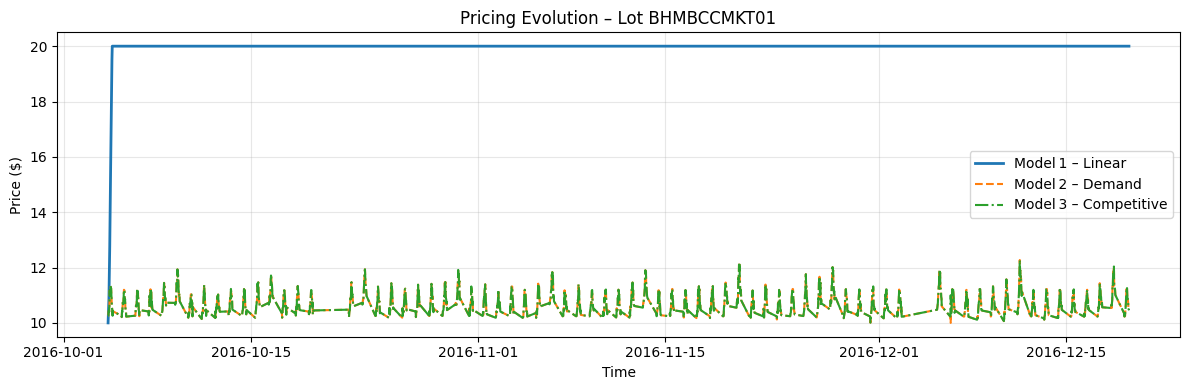

In [118]:
import matplotlib.pyplot as plt

# 🔧 Ensure index is clean
df = df.loc[:, ~df.columns.duplicated()]     # remove any duplicate columns
df = df.reset_index(drop=True)               # fix duplicate row labels

# ── pick the first lot robustly ──
lot_id = df['parking_id'].drop_duplicates().iloc[0]

# ── slice & sort ──
lot_df = df[df['parking_id'] == lot_id].sort_values('timestamp')

# ── plot ──
plt.figure(figsize=(12, 4))

plt.plot(lot_df['timestamp'], lot_df['price_lin'],
         label='Model 1 – Linear', linewidth=2)

plt.plot(lot_df['timestamp'], lot_df['price_demand'],
         label='Model 2 – Demand', linestyle='--')

plt.plot(lot_df['timestamp'], lot_df['price_competitive'],
         label='Model 3 – Competitive', linestyle='-.')

plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.title(f'Pricing Evolution – Lot {lot_id}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [119]:
vt_clean = df['vehicle_type'].astype(str).str.strip().str.lower()

vehicle_map = {
    'car':   1.0,
    'bike':  0.7,
    'truck': 1.5
}

df['vehicle_weight'] = vt_clean.map(vehicle_map).fillna(1.0)


In [120]:
LAMBDA = 0.8
PRICE_MIN, PRICE_MAX = 5, 20
WEIGHTS = dict(queue=0.5, traffic=-0.3, special=1.0, vehicle=0.2)

def demand_score(r):
    s  = (r.occupancy / r.capacity)
    s += WEIGHTS['queue']   * r.queue_length
    s += WEIGHTS['traffic'] * r.traffic
    s += WEIGHTS['special'] * r.is_special_day
    s += WEIGHTS['vehicle'] * r.vehicle_weight
    return s

def apply_demand(g):
    d_raw  = g.apply(demand_score, axis=1)
    d_norm = (d_raw - d_raw.min()) / (d_raw.max() - d_raw.min() + 1e-9)
    price  = BASE_PRICE * (1 + LAMBDA * d_norm)
    return price.clip(PRICE_MIN, PRICE_MAX)

df['price_demand'] = df.groupby('parking_id', group_keys=False).apply(apply_demand)


/tmp/ipython-input-120-4178987733.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['price_demand'] = df.groupby('parking_id', group_keys=False).apply(apply_demand)


In [121]:
from geopy.distance import geodesic

# Build a mapping: lot_id → (lat, long)
location_map = df.groupby('parking_id')[['Latitude', 'Longitude']].first().to_dict('index')

def compute_distance(lot1, lot2):
    loc1 = (location_map[lot1]['Latitude'], location_map[lot1]['Longitude'])
    loc2 = (location_map[lot2]['Latitude'], location_map[lot2]['Longitude'])
    return geodesic(loc1, loc2).meters


In [122]:
from math import radians, sin, cos, sqrt, atan2

# Step 1: Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius (km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Step 2: Get lat/lon for each lot
lot_coords = df.groupby('parking_id')[['Latitude', 'Longitude']].mean()

# Step 3: Build proximity map
proximity_map = {}

for lot_id, (lat1, lon1) in lot_coords.iterrows():
    nearby_lots = []
    for other_id, (lat2, lon2) in lot_coords.iterrows():
        if lot_id == other_id:
            continue
        distance = haversine(lat1, lon1, lat2, lon2)
        if distance <= 0.5:
            nearby_lots.append(other_id)
    proximity_map[lot_id] = nearby_lots


In [123]:
# ─── 1️⃣ Build a timestamp × lot matrix of demand prices ───
# Use pivot_table to avoid duplicate entry errors
price_matrix = (
    df.pivot_table(index='timestamp', columns='parking_id', values='price_demand', aggfunc='mean')
)

# ─── 2️⃣ Precompute average competitor price for every lot/time ───
comp_avg_dict = {}
for lot, comps in proximity_map.items():
    if comps:  # has nearby competitors
        comp_avg_dict[lot] = price_matrix[comps].mean(axis=1)
    else:      # fallback: use own price
        comp_avg_dict[lot] = price_matrix[lot]

# Convert dictionary to long DataFrame
comp_avg_df = pd.DataFrame(comp_avg_dict)  # index = timestamp, columns = lot
comp_avg_long = (
    comp_avg_df.stack()
    .rename('avg_comp_price')
    .reset_index()
    .rename(columns={'level_1': 'parking_id'})  # rename to match df columns
)

# ─── 3️⃣ Merge back & apply vectorized adjustment ───
df = (
    df.merge(comp_avg_long, on=['timestamp', 'parking_id'], how='left')
      .assign(price_competitive = df['price_demand'])  # start with demand price
)

# Define adjustment rules:
cut_mask  = (df['occupancy'] >= 0.9 * df['capacity']) & (df['price_demand'] > df['avg_comp_price'])
bump_mask = (df['occupancy'] <= 0.4 * df['capacity']) & (df['price_demand'] < df['avg_comp_price'])

# Apply the changes:
df.loc[cut_mask, 'price_competitive'] = df.loc[cut_mask, 'avg_comp_price']
df.loc[bump_mask, 'price_competitive'] = (
    df.loc[bump_mask, 'price_demand'] + 1
).clip(upper=PRICE_MAX)

# Cleanup (optional)
df.drop(columns='avg_comp_price', inplace=True)


In [124]:
final_cols = [
    'parking_id', 'timestamp', 'occupancy', 'capacity', 'queue_length',
    'price_lin', 'price_demand', 'price_competitive'
]

df[final_cols].to_csv('final_pricing_output.csv', index=False)
print("✅ Final file saved → final_pricing_output.csv")


✅ Final file saved → final_pricing_output.csv


Chosen lot BHMBCCMKT01 with 1312 rows


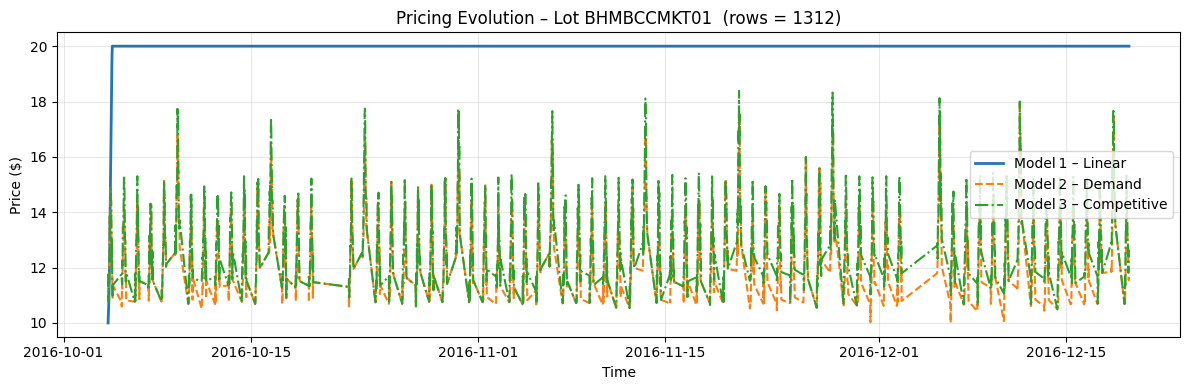

In [125]:
import matplotlib.pyplot as plt
import pandas as pd

# ── CLEAN UP ────────────────────────────────────────────────────────────────
df = df.loc[:, ~df.columns.duplicated()]        # drop duplicate‑named cols
df = df.reset_index(drop=True)                  # fix duplicate row labels
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# ── PICK LOT WITH MOST DATA ────────────────────────────────────────────────
lot_counts = df['parking_id'].value_counts()      # rows per lot
lot_id = lot_counts.idxmax()
rows   = lot_counts.max()

print(f"Chosen lot {lot_id} with {rows} rows")

lot_df = (df[df['parking_id'] == lot_id]
          .dropna(subset=['timestamp', 'price_lin',
                          'price_demand', 'price_competitive'])
          .sort_values('timestamp'))

# ── PLOT IF WE HAVE >1 ROW ─────────────────────────────────────────────────
if len(lot_df) > 1:
    plt.figure(figsize=(12, 4))
    plt.plot(lot_df['timestamp'], lot_df['price_lin'],         label='Model 1 – Linear',       linewidth=2)
    plt.plot(lot_df['timestamp'], lot_df['price_demand'],      label='Model 2 – Demand',       linestyle='--')
    plt.plot(lot_df['timestamp'], lot_df['price_competitive'], label='Model 3 – Competitive',  linestyle='-.')
    plt.xlabel('Time'); plt.ylabel('Price ($)')
    plt.title(f'Pricing Evolution – Lot {lot_id}  (rows = {len(lot_df)})')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
else:
    print(f"Lot {lot_id} still has only {len(lot_df)} row — check earlier steps (timestamp or price columns).")
    show(p)


In [126]:
import pathway as pw
import pathway.debug


In [127]:
class ParkingSchema(pw.Schema):
    ID: int
    SystemCodeNumber: str
    Capacity: int
    Latitude: float
    Longitude: float
    Occupancy: int
    VehicleType: str
    TrafficConditionNearby: str
    QueueLength: int
    IsSpecialDay: int
    LastUpdatedDate: str
    LastUpdatedTime: str


In [128]:
input_stream = pw.io.csv.read(
    "dataset.csv",
    schema=ParkingSchema,
    mode="streaming",                  # Simulate real-time input
    autocommit_duration_ms=300        # Commit batches every 0.5 seconds
)


In [129]:
@pw.udf
def compute_price(occupancy, capacity, queue, traffic, special, vtype):
    traffic_map = {'low': 1, 'average': 2, 'high': 3}
    vehicle_map = {'car': 1.0, 'bike': 0.7, 'truck': 1.5}

    traffic_val = traffic_map.get(traffic.lower(), 2)
    vehicle_weight = vehicle_map.get(vtype.lower(), 1.0)
    occ_ratio = occupancy / capacity

    demand = (
        1.2 * occ_ratio +
        0.5 * queue -
        0.3 * traffic_val +
        1.0 * special +
        0.7 * vehicle_weight
    )

    norm_demand = max(0, min(1, demand / 10))
    price = 10 * (1 + 0.3 * norm_demand)
    return max(5, min(20, price))


In [ ]:
output_stream = input_stream.select(
    Time=input_stream.LastUpdatedTime,
    Lot=input_stream.SystemCodeNumber,
    Price=compute_price(
        input_stream.Occupancy,
        input_stream.Capacity,
        input_stream.QueueLength,
        input_stream.TrafficConditionNearby,
        input_stream.IsSpecialDay,
        input_stream.VehicleType
    )
)


In [130]:
!pip install bokeh


In [131]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
from IPython.display import display
import pandas as pd
import time

output_notebook()

# Initialize empty source
source = ColumnDataSource(data=dict(Time=[], Price=[]))

p = figure(title="Real-Time Pricing", x_axis_label='Time', y_axis_label='Price ($)', x_axis_type='auto')
p.line(x='Time', y='Price', source=source, line_width=2, color='blue')

handle = show(p, notebook_handle=True)


In [132]:
def update_live_plot(file="realtime_output.csv", duration=30):
    start = time.time()
    last_count = 0
    while time.time() - start < duration:
        try:
            df = pd.read_csv(file)
            if len(df) > last_count:
                # Update only with new rows
                new_rows = df.iloc[last_count:]
                source.stream({
                    'Time': new_rows['Time'].tolist(),
                    'Price': new_rows['Price'].tolist()
                })
                last_count = len(df)
                push_notebook(handle=handle)
        except:
            pass
        time.sleep(1)  # Update every 1s


In [ ]:
update_live_plot("realtime_output.csv", duration=60)  # 60 seconds


In [ ]:
pw.io.csv.write(output_stream, "realtime_output.csv")
pw.run()
